In [ ]:
%load_ext autoreload
%autoreload 2

import sys 
from os import getcwd, path
import os
sys.path.append(path.dirname(getcwd()))
import matplotlib.pyplot as plt
import seaborn as sb
import ggplot as ggplot
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import lifelines as ll
import patsy as patsy
import numpy as np
import pandas as pd
import functools
import survivalstan
import stanity
%matplotlib inline
from utils import data
from utils import paper
from cohorts.functions import *

In [2]:
## prep for rpy2
## this will be the r-lib-path, location where installed R packages will be stored
r_lib_path = os.path.join(os.path.dirname(getcwd()),'Ranalyses','.R_env')
if not os.path.exists(r_lib_path):
    print("R lib path doesn't exist. Creating it.")
    os.mkdir(r_lib_path)
assert(os.path.exists(r_lib_path))

In [3]:
## set up rpy2
import rpy2
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
R = ro.r
%load_ext rpy2.ipython
ro.globalenv['r_lib_path'] = r_lib_path

In [4]:
%%R
## make sure R packages can be installed to the lib-path
.libPaths(new = r_lib_path)
options(repos = c(CRAN = 'https://cran.rstudio.com'))
if (!require('survival', lib.loc = r_lib_path))
    install.packages('survival', lib = r_lib_path)
if (!require('dplyr', lib.loc = r_lib_path))
    install.packages('dplyr', lib = r_lib_path)

library('survival', lib.loc = r_lib_path)
library('dplyr', lib.loc = r_lib_path)

/home/tavi/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Error in .External2(C_X11, paste("png::", filename, sep = ""), g$width,  : 
  unable to start device PNG

  warnings.warn(x, RRuntimeWarning)
/home/tavi/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/home/tavi/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning message:

  warnings.warn(x, RRuntimeWarning)
/home/tavi/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: In (function (filename = "Rplot%03d.png", width = 480, height = 480,  :
  warnings.warn(x, RRuntimeWarning)
/home/tavi/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 
 
  warnings.warn(x, RRuntimeWarning)
/home/tavi/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  unable

RRuntimeError: Error in .External2(C_X11, paste("png::", filename, sep = ""), g$width,  : 
  unable to start device PNG


## Prep/load data

In [5]:
## adapted from TCR plots.ipynb
cohort = data.init_cohort(join_with=["tcr_peripheral_a","ensembl_coverage"])

inner join with ensembl_coverage: 25 to 25 rows
inner join with tcr_peripheral_a: 25 to 25 rows
inner join with ensembl_coverage: 25 to 25 rows
inner join with tcr_peripheral_a: 25 to 25 rows
{'dataframe_hash': -7522244498661454348,
 'provenance_file_summary': {u'cohorts': u'0.4.0+3.gda968fb',
                             u'isovar': u'0.0.6',
                             u'mhctools': u'0.3.0',
                             u'numpy': u'1.11.1',
                             u'pandas': u'0.18.1',
                             u'pyensembl': u'1.0.3',
                             u'scipy': u'0.18.1',
                             u'topiary': u'0.1.0',
                             u'varcode': u'0.5.10'}}


In [6]:
cols, d = cohort.as_dataframe(on={"peripheral_a_clonality": lambda row: row["Clonality"], 
                                  "missense_snv_count": missense_snv_count,
                                  "expressed_neoantigen_count": expressed_neoantigen_count,
                                 }, return_cols=True)

inner join with ensembl_coverage: 25 to 25 rows
inner join with tcr_peripheral_a: 25 to 25 rows
inner join with ensembl_coverage: 25 to 25 rows


In [7]:
len(d)

25

In [8]:
## construct log-transformed / centered missense_snv_count metric
d['missense_snv_per_mb'] = d.missense_snv_count / d.MB
d['log_mut'] = np.log1p(d.missense_snv_count)
d['log_mut_centered'] = d.log_mut - d.log_mut.mean()
d['log_neoant'] = np.log1p(d.expressed_neoantigen_count)
d['log_neoant_centered'] = d.log_neoant - d.log_neoant.mean()
d['neoant_mutation_ratio'] = d.expressed_neoantigen_count / d.missense_snv_count

## define output variables of interest
time_col = 'pfs'
event_col = 'is_progressed_or_deceased'

## reshape to long
dlong = survivalstan.prep_data_long_surv(df = d, time_col = 'pfs', event_col = 'is_progressed_or_deceased')
dlong_os = survivalstan.prep_data_long_surv(df = d, time_col = 'os', event_col = 'is_deceased')

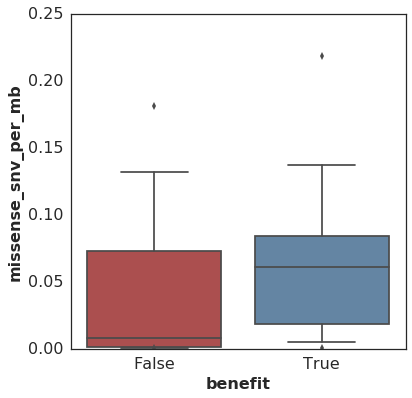

In [9]:
sb.boxplot(y = 'missense_snv_per_mb', x = 'benefit', data = d, whis=[2.5, 97.5],)

In [10]:
def coxph_model(formula, data, time_col, event_col, **kwargs):
    sdata = patsy.dmatrix(
        formula
         , data = data
         , return_type = 'dataframe'
         ).join(data[[time_col, event_col]])
    sdata = sdata.ix[:, sdata.columns != 'Intercept']
    
    if not(hasattr(kwargs, "penalizer")):
        kwargs["penalizer"] = 0.1
    if not(hasattr(kwargs, "normalize")):
        kwargs['normalize'] = False
    
    cf = ll.CoxPHFitter(**kwargs)
    cf.fit(sdata
          , time_col
          , event_col
          )
    cf.print_summary()
    return cf


In [11]:
coxph_pfs = functools.partial(coxph_model, time_col = 'pfs', event_col = 'is_progressed_or_deceased', data = d)
coxph_os = functools.partial(coxph_model, time_col = 'os', event_col = 'is_deceased', data = d)

## fit cox model using Python

In [12]:
coxph_pfs(data = d, formula = 'missense_snv_count')
coxph_os(data = d, formula = 'missense_snv_count')

n=25, number of events=19

                         coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95   
missense_snv_count -8.044e-02  9.227e-01 8.402e-02 -9.573e-01 3.384e-01  -2.452e-01   8.428e-02   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.550
n=25, number of events=17

                         coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95   
missense_snv_count -4.926e-02  9.519e-01 8.334e-02 -5.911e-01 5.545e-01  -2.126e-01   1.141e-01   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.544


/home/tavi/.local/lib/python2.7/site-packages/lifelines/fitters/coxph_fitter.py:285: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df.sort(duration_col, inplace=True)


<lifelines.CoxPHFitter: fitted with 25 observations, 8 censored>

## fit cox model using R

In [13]:
## prep data to export to R environment
## (in absence of this, get strange behavior for some logical columns)
## for now, export the minimal number of columns necessary
columns = ['benefit', event_col, time_col, 'missense_snv_count', 'patient_id']
d_for_r = d.loc[:,columns]
dlong_for_r = survivalstan.prep_data_long_surv(d_for_r, event_col = event_col, time_col = time_col)
dlong_for_r['end_failure'] = dlong_for_r['end_failure'].astype(int)
dlong_for_r['benefit'] = dlong_for_r['benefit'].astype(int)
dlong_for_r['is_progressed_or_deceased'] = dlong_for_r['is_progressed_or_deceased'].astype(int)

## export data to R
ro.globalenv['d'] = d_for_r
ro.globalenv['dlong'] = dlong_for_r
ro.globalenv['time_col'] = time_col
ro.globalenv['event_col'] = event_col

In [14]:
## prep data for OS-based analysis
columns = ['benefit', 'is_deceased', 'os', 'missense_snv_count', 'patient_id']
d2_for_r = d.loc[:,columns]
dlong2_for_r = survivalstan.prep_data_long_surv(d2_for_r, event_col = 'is_deceased', time_col = 'os')
dlong2_for_r['end_failure'] = dlong2_for_r['end_failure'].astype(int)
dlong2_for_r['benefit'] = dlong2_for_r['benefit'].astype(int)
dlong2_for_r['is_deceased'] = dlong2_for_r['is_deceased'].astype(int)

## export data to R
ro.globalenv['d_os'] = d2_for_r
ro.globalenv['dlong_os'] = dlong2_for_r
ro.globalenv['time_col_os'] = 'os'
ro.globalenv['event_col_os'] = 'is_deceased'

In [15]:
%%R
library(survival)
library(dplyr)

In [16]:
%R str(d)

'data.frame':	25 obs. of  6 variables:
 $ benefit                  : logi  FALSE FALSE FALSE TRUE FALSE TRUE ...
 $ is_progressed_or_deceased: logi  TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ pfs                      : int  20 61 58 398 41 265 121 560 655 646 ...
 $ missense_snv_count       : num  9.898 3.7204 0.4263 0.0377 4.2359 ...
 $ patient_id               : Factor w/ 25 levels "0040","0471",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ key                      : int  1 1 1 1 1 1 1 1 1 1 ...


In [17]:
%R str(dlong)

'data.frame':	263 obs. of  8 variables:
 $ benefit                  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ is_progressed_or_deceased: int  1 1 1 1 1 1 1 1 1 1 ...
 $ pfs                      : int  20 20 61 61 61 61 61 61 61 58 ...
 $ missense_snv_count       : num  9.9 9.9 3.72 3.72 3.72 ...
 $ patient_id               : Factor w/ 25 levels "0040","0471",..: 1 1 2 2 2 2 2 2 2 3 ...
 $ key                      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ end_time                 : int  20 19 20 61 58 41 37 60 19 20 ...
 $ end_failure              : int  1 0 0 1 0 0 0 0 0 0 ...


In [18]:
%R str(dlong_os)

'data.frame':	320 obs. of  8 variables:
 $ benefit           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ is_deceased       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ os                : int  24 24 329 329 329 329 329 329 329 329 ...
 $ missense_snv_count: num  9.9 9.9 3.72 3.72 3.72 ...
 $ patient_id        : Factor w/ 25 levels "0040","0471",..: 1 1 2 2 2 2 2 2 2 2 ...
 $ key               : int  1 1 1 1 1 1 1 1 1 1 ...
 $ end_time          : int  24 22 24 329 76 54 44 182 266 163 ...
 $ end_failure       : int  1 0 0 1 0 0 0 0 0 0 ...


In [19]:
## example calling GLM 
%R print(summary(glm('benefit~missense_snv_count', data=d, family = 'binomial')))


Call:
glm(formula = "benefit~missense_snv_count", family = "binomial", 
    data = d)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2762  -0.9370  -0.8243   1.3605   1.5787  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)
(Intercept)         -0.9114     0.5726  -1.592    0.111
missense_snv_count   0.1152     0.1282   0.899    0.369

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 32.671  on 24  degrees of freedom
Residual deviance: 31.847  on 23  degrees of freedom
AIC: 35.847

Number of Fisher Scoring iterations: 4



In [20]:
%%R
print_for_hyper <- function(label, value) {
    print(paste('{{{',label,':',value,'}}}', sep=''))
}
format_hr <- function(coxres, coef, digits = 2) {
    confint <- summary(coxres)$conf.int[coef,]
    formatted <- paste('n=25, HR=', 
                       round(confint['exp(coef)'], digits),
                       ' (95% CI ',
                       round(confint['lower .95'], digits),
                       ' - ',
                       round(confint['upper .95'], digits),
                       ')',
                        sep = '')
    formatted
}
format_hr_inline <- function(coxres, coef, digits = 2) {
    confint <- summary(coxres)$conf.int[coef,]
    formatted <- paste(round(confint['exp(coef)'], digits),
                       ' (95% CI ',
                       round(confint['lower .95'], digits),
                       ' - ',
                       round(confint['upper .95'], digits),
                       ')',
                        sep = '')
    formatted
}
format_p_zph <- function(test_zph, coef, digits = 2, n = NULL) {
    p_value <- test_zph$table[coef, 'p']
    p_value <- format.pval(p_value, digits=digits)
    if (is.null(n)) {
        return(p_value)
    } else {
        return(paste('n=',n,', p=',p_value,sep=''))
    }
}

### primary model for PFS

In [21]:
%%R 
surv_time = as.formula(paste('Surv(',time_col,',',event_col,') ~ .'))
print(surv_time)

Surv(pfs, is_progressed_or_deceased) ~ .


In [22]:
%%R 
coxres <- 
    coxph(
        update(surv_time, '~ missense_snv_count'),
        data = d, 
        method="breslow",
        na.action=na.exclude
    )
print(summary(coxres))

Call:
coxph(formula = update(surv_time, "~ missense_snv_count"), data = d, 
    na.action = na.exclude, method = "breslow")

  n= 25, number of events= 19 

                       coef exp(coef) se(coef)      z Pr(>|z|)
missense_snv_count -0.08049   0.92266  0.08406 -0.958    0.338

                   exp(coef) exp(-coef) lower .95 upper .95
missense_snv_count    0.9227      1.084    0.7825     1.088

Concordance= 0.55  (se = 0.077 )
Rsquare= 0.041   (max possible= 0.984 )
Likelihood ratio test= 1.03  on 1 df,   p=0.3091
Wald test            = 0.92  on 1 df,   p=0.3383
Score (logrank) test = 0.93  on 1 df,   p=0.3346



#### test for non-proportional hazard of missense_snv_count

                     rho chisq      p
missense_snv_count -0.45  4.05 0.0441


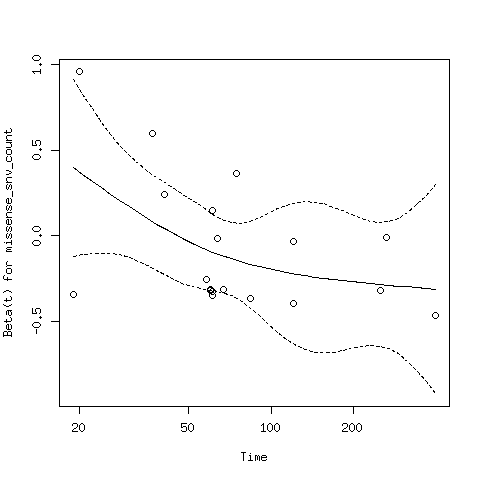

In [23]:
%%R
test_nph = cox.zph(coxres, transform = 'log')
plot(test_nph)
print(test_nph)

In [24]:
%%R
print_for_hyper(label = 'p_nph_pfs', value = format_p_zph(test_nph, 'missense_snv_count', n=25))

[1] "{{{p_nph_pfs:n=25, p=0.044}}}"


#### log-transformed mutation count

Call:
coxph(formula = update(surv_time, "~ log_mut"), data = d2, na.action = na.exclude, 
    method = "breslow")

  n= 25, number of events= 19 

           coef exp(coef) se(coef)      z Pr(>|z|)
log_mut -0.3304    0.7186   0.2966 -1.114    0.265

        exp(coef) exp(-coef) lower .95 upper .95
log_mut    0.7186      1.392    0.4018     1.285

Concordance= 0.55  (se = 0.077 )
Rsquare= 0.05   (max possible= 0.984 )
Likelihood ratio test= 1.29  on 1 df,   p=0.2552
Wald test            = 1.24  on 1 df,   p=0.2653
Score (logrank) test = 1.26  on 1 df,   p=0.2615

           rho chisq     p
log_mut -0.343  2.44 0.118


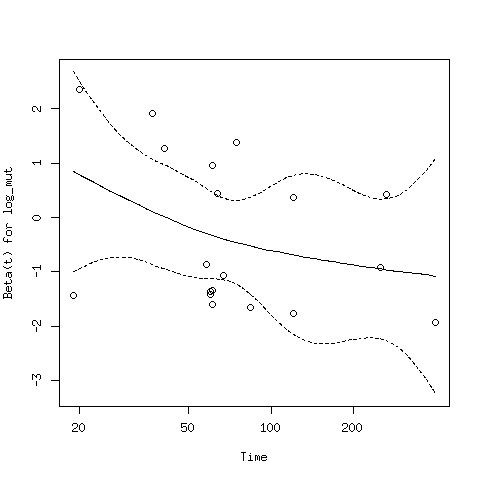

In [25]:
%%R 
d2 <- 
  d %>%
  dplyr::mutate(log_mut = log1p(missense_snv_count))

coxres2 <- 
    coxph(
        update(surv_time, '~ log_mut'),
        data = d2, 
        method="breslow",
        na.action=na.exclude
    )
print(summary(coxres2))
test_nph2 = cox.zph(coxres2, transform = 'log')
plot(test_nph2)
print(test_nph2)

#### alternate long-data spec

In [26]:
%%R
str(dlong)

'data.frame':	263 obs. of  8 variables:
 $ benefit                  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ is_progressed_or_deceased: int  1 1 1 1 1 1 1 1 1 1 ...
 $ pfs                      : int  20 20 61 61 61 61 61 61 61 58 ...
 $ missense_snv_count       : num  9.9 9.9 3.72 3.72 3.72 ...
 $ patient_id               : Factor w/ 25 levels "0040","0471",..: 1 1 2 2 2 2 2 2 2 3 ...
 $ key                      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ end_time                 : int  20 19 20 61 58 41 37 60 19 20 ...
 $ end_failure              : int  1 0 0 1 0 0 0 0 0 0 ...


In [27]:
%%R
## add start time to timepoint
coxres_alt <- 
  coxph(as.formula('Surv(end_time, end_failure) ~ missense_snv_count + cluster(patient_id)'),
        data = dlong,
        method="breslow",
        na.action=na.exclude
       )

In [28]:
%R print(summary(coxres_alt))

Call:
coxph(formula = as.formula("Surv(end_time, end_failure) ~ missense_snv_count + cluster(patient_id)"), 
    data = dlong, na.action = na.exclude, method = "breslow")

  n= 263, number of events= 19 

                       coef exp(coef) se(coef) robust se      z Pr(>|z|)
missense_snv_count -0.10340   0.90176  0.08558   0.11657 -0.887    0.375

                   exp(coef) exp(-coef) lower .95 upper .95
missense_snv_count    0.9018      1.109    0.7176     1.133

Concordance= 0.562  (se = 0.076 )
Rsquare= 0.007   (max possible= 0.488 )
Likelihood ratio test= 1.72  on 1 df,   p=0.1892
Wald test            = 0.79  on 1 df,   p=0.3751
Score (logrank) test = 1.5  on 1 df,   p=0.2208,   Robust = 0.73  p=0.3915

  (Note: the likelihood ratio and score tests assume independence of
     observations within a cluster, the Wald and robust score tests do not).


In [29]:
## compare to original spec of model
%R print(summary(coxres))

Call:
coxph(formula = update(surv_time, "~ missense_snv_count"), data = d, 
    na.action = na.exclude, method = "breslow")

  n= 25, number of events= 19 

                       coef exp(coef) se(coef)      z Pr(>|z|)
missense_snv_count -0.08049   0.92266  0.08406 -0.958    0.338

                   exp(coef) exp(-coef) lower .95 upper .95
missense_snv_count    0.9227      1.084    0.7825     1.088

Concordance= 0.55  (se = 0.077 )
Rsquare= 0.041   (max possible= 0.984 )
Likelihood ratio test= 1.03  on 1 df,   p=0.3091
Wald test            = 0.92  on 1 df,   p=0.3383
Score (logrank) test = 0.93  on 1 df,   p=0.3346



In [30]:
%%R
print_for_hyper(label = 'hr_missense_snv_pfs_cox', 
                value = format_hr(coxres, 'missense_snv_count')
               )
print_for_hyper(label = 'hr_missense_snv_pfs_cox_inline', 
                value = format_hr_inline(coxres, 'missense_snv_count')
               )


[1] "{{{hr_missense_snv_pfs_cox:n=25, HR=0.92 (95% CI 0.78 - 1.09)}}}"
[1] "{{{hr_missense_snv_pfs_cox_inline:0.92 (95% CI 0.78 - 1.09)}}}"


In [31]:
%%R
print_for_hyper(label = 'hr_log_missense_snv_pfs_cox', 
                value = format_hr(coxres2, 'log_mut')
               )

[1] "{{{hr_log_missense_snv_pfs_cox:n=25, HR=0.72 (95% CI 0.4 - 1.29)}}}"


#### test for difference at 90d

In [32]:
%%R
## add start time to timepoint
dlong2 <- 
    dlong %>%
    dplyr::mutate(gt_91_days = ifelse(end_time > 91, 1, 0),
                  lt_91_days = ifelse(end_time <= 91, 1, 0))


coxres_alt_time <- 
  coxph(as.formula('Surv(end_time, end_failure) ~ missense_snv_count:lt_91_days + missense_snv_count:gt_91_days + cluster(patient_id)'),
        data = dlong2,
        method="breslow",
        na.action=na.exclude
       )
print(summary(coxres_alt_time))

Call:
coxph(formula = as.formula("Surv(end_time, end_failure) ~ missense_snv_count:lt_91_days + missense_snv_count:gt_91_days + cluster(patient_id)"), 
    data = dlong2, na.action = na.exclude, method = "breslow")

  n= 263, number of events= 19 

                                  coef exp(coef) se(coef) robust se      z
missense_snv_count:lt_91_days  0.03803   1.03876  0.08203   0.10457  0.364
missense_snv_count:gt_91_days -0.53482   0.58577  0.27137   0.29608 -1.806
                              Pr(>|z|)  
missense_snv_count:lt_91_days   0.7161  
missense_snv_count:gt_91_days   0.0709 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                              exp(coef) exp(-coef) lower .95 upper .95
missense_snv_count:lt_91_days    1.0388     0.9627    0.8463     1.275
missense_snv_count:gt_91_days    0.5858     1.7071    0.3279     1.047

Concordance= 0.693  (se = 0.076 )
Rsquare= 0.038   (max possible= 0.488 )
Likelihood ratio test= 10.17  on 2 df,   p=0.00

In [33]:
%%R
## print out number of patients with >90d pfs 
## in hyper-friendly way
num_patients <-
    dlong2 %>% 
    dplyr::filter(gt_91_days==TRUE) %>%
    distinct(patient_id) %>%
    tally()
print_for_hyper('num_patients_gt_90d_pfs',num_patients)


[1] "{{{num_patients_gt_90d_pfs:11}}}"


In [34]:
%%R
print_for_hyper(label = 'hr_lt_90d_pfs_cox', 
                value = format_hr(coxres_alt_time, 'missense_snv_count:lt_91_days')
               )
print_for_hyper(label = 'hr_gt_90d_pfs_cox', 
                value = format_hr(coxres_alt_time, 'missense_snv_count:gt_91_days')
               )


[1] "{{{hr_lt_90d_pfs_cox:n=25, HR=1.04 (95% CI 0.85 - 1.28)}}}"
[1] "{{{hr_gt_90d_pfs_cox:n=25, HR=0.59 (95% CI 0.33 - 1.05)}}}"


#### same analysis using log-mut-count

In [35]:
%%R
## add start time to timepoint
dlong2 <- 
    dlong %>%
    dplyr::mutate(gt_91_days = ifelse(end_time > 91, 1, 0),
                  lt_91_days = ifelse(end_time <= 91, 1, 0),
                  log_mut = log1p(missense_snv_count))
coxres_alt_time <- 
  coxph(as.formula('Surv(end_time, end_failure) ~ log_mut:lt_91_days + log_mut:gt_91_days + cluster(patient_id)'),
        data = dlong2,
        method="breslow",
        na.action=na.exclude
       )
print(summary(coxres_alt_time))


Call:
coxph(formula = as.formula("Surv(end_time, end_failure) ~ log_mut:lt_91_days + log_mut:gt_91_days + cluster(patient_id)"), 
    data = dlong2, na.action = na.exclude, method = "breslow")

  n= 263, number of events= 19 

                       coef exp(coef) se(coef) robust se      z Pr(>|z|)  
log_mut:lt_91_days  0.09686   1.10171  0.32440   0.40902  0.237   0.8128  
log_mut:gt_91_days -1.53533   0.21538  0.65495   0.71831 -2.137   0.0326 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   exp(coef) exp(-coef) lower .95 upper .95
log_mut:lt_91_days    1.1017     0.9077    0.4942    2.4560
log_mut:gt_91_days    0.2154     4.6429    0.0527    0.8803

Concordance= 0.693  (se = 0.076 )
Rsquare= 0.042   (max possible= 0.488 )
Likelihood ratio test= 11.2  on 2 df,   p=0.003697
Wald test            = 5.94  on 2 df,   p=0.05125
Score (logrank) test = 8  on 2 df,   p=0.01836,   Robust = 9.31  p=0.009499

  (Note: the likelihood ratio and score tests a

### primary model for OS

In [36]:
%%R 
surv_time_os = as.formula(paste('Surv(',time_col_os,',',event_col_os,') ~ .'))
print(surv_time_os)


Surv(os, is_deceased) ~ .


In [37]:
%%R 
coxres_os <- 
    coxph(
        update(surv_time_os, '~ missense_snv_count'),
        data = d_os, 
        method="breslow",
        na.action=na.exclude
    )
print(summary(coxres_os))

Call:
coxph(formula = update(surv_time_os, "~ missense_snv_count"), 
    data = d_os, na.action = na.exclude, method = "breslow")

  n= 25, number of events= 17 

                       coef exp(coef) se(coef)      z Pr(>|z|)
missense_snv_count -0.04929   0.95190  0.08338 -0.591    0.554

                   exp(coef) exp(-coef) lower .95 upper .95
missense_snv_count    0.9519      1.051    0.8084     1.121

Concordance= 0.544  (se = 0.077 )
Rsquare= 0.015   (max possible= 0.977 )
Likelihood ratio test= 0.37  on 1 df,   p=0.5404
Wald test            = 0.35  on 1 df,   p=0.5544
Score (logrank) test = 0.35  on 1 df,   p=0.5533



#### test for time-varying effect using OS

                      rho chisq      p
missense_snv_count -0.435  3.02 0.0821


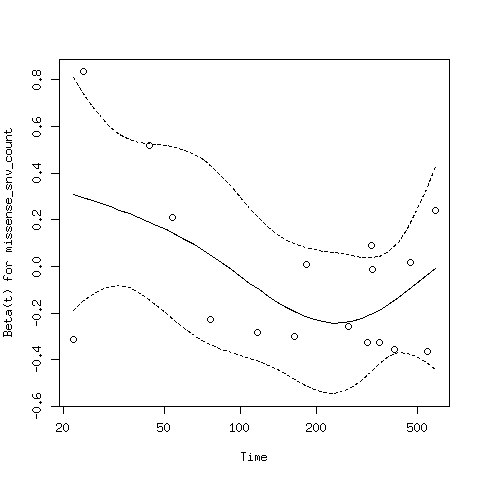

In [38]:
%%R
test_nph_os = cox.zph(coxres_os, transform = 'log')
plot(test_nph_os)
print(test_nph_os)

In [39]:
%%R
print_for_hyper(label = 'p_nph_os', value = format_p_zph(test_nph_os, 'missense_snv_count', n=25))

[1] "{{{p_nph_os:n=25, p=0.082}}}"


#### test for difference at 90 days

In [40]:
%%R
## add start time to timepoint
dlong2_os <- 
    dlong_os %>%
    dplyr::mutate(gt_90_days = ifelse(end_time > 90, 1, 0),
                  lt_90_days = ifelse(end_time <= 90, 1, 0))
coxres_alt_time_os <- 
  coxph(as.formula('Surv(end_time, end_failure) ~ missense_snv_count:lt_90_days + missense_snv_count:gt_90_days + cluster(patient_id)'),
        data = dlong2_os,
        method="breslow",
        na.action=na.exclude
       )
print(summary(coxres_alt_time_os))

Call:
coxph(formula = as.formula("Surv(end_time, end_failure) ~ missense_snv_count:lt_90_days + missense_snv_count:gt_90_days + cluster(patient_id)"), 
    data = dlong2_os, na.action = na.exclude, method = "breslow")

  n= 320, number of events= 17 

                                  coef exp(coef) se(coef) robust se      z
missense_snv_count:lt_90_days  0.30708   1.35945  0.09771   0.11206  2.740
missense_snv_count:gt_90_days -0.21155   0.80933  0.13162   0.13567 -1.559
                              Pr(>|z|)   
missense_snv_count:lt_90_days  0.00614 **
missense_snv_count:gt_90_days  0.11894   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                              exp(coef) exp(-coef) lower .95 upper .95
missense_snv_count:lt_90_days    1.3594     0.7356    1.0914     1.693
missense_snv_count:gt_90_days    0.8093     1.2356    0.6204     1.056

Concordance= 0.814  (se = 0.08 )
Rsquare= 0.036   (max possible= 0.406 )
Likelihood ratio test= 11.89  on 2 df,   p

In [41]:
%%R
print_for_hyper(label = 'hr_lt_90d_os_cox', 
                value = format_hr(coxres_alt_time_os, 'missense_snv_count:lt_90_days')
               )
print_for_hyper(label = 'hr_gt_90d_os_cox', 
                value = format_hr(coxres_alt_time_os, 'missense_snv_count:gt_90_days')
               )


[1] "{{{hr_lt_90d_os_cox:n=25, HR=1.36 (95% CI 1.09 - 1.69)}}}"
[1] "{{{hr_gt_90d_os_cox:n=25, HR=0.81 (95% CI 0.62 - 1.06)}}}"


## fit survival model in stan

### fit both rw & gamma PEM models

In [42]:
## load stan models
models = survivalstan.utils.read_files('../utils/stan', pattern = "*.stan")

../utils/stan/logistic_model.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_expressed_missense_and_neoant_mutations.stan
../utils/stan/logistic_model_by_group.stan
../utils/stan/pem_survival_model_unstructured_varcoef.stan
../utils/stan/pem_survival_model_unstructured_varcoef_hsprior.stan
../utils/stan/pem_survival_model_randomwalk_tvc.stan
../utils/stan/pem_survival_model_randomwalk_alt.stan
../utils/stan/pem_survival_model_randomwalk_bspline_est_xi.stan
../utils/stan/pem_survival_model_varying_coefs3.stan
../utils/stan/pem_survival_model_randomwalk.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_rate_only.stan
../utils/stan/pem_survival_model_gamma.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_missense_and_neoant_rates.stan
../utils/stan/pem_survival_model_randomwalk_tvc2.stan
../utils/stan/pem_survival_model_varying_coefs2.stan
../utils/stan/pem_survival_model_varying_coefs4.stan
../utils/stan/pem_survival_model_randomwalk_bspline_est_xi2

In [43]:
gamma_model = survivalstan.fit_stan_survival_model(
    formula = '~ missense_snv_count',
    df = dlong,
    timepoint_end_col = 'end_time',
    sample_col = 'patient_id',
    event_col = 'end_failure',
    chains = 4,
    iter = 1000,
    model_code = models['pem_survival_model_gamma.stan'],
    model_cohort = 'gamma prior'
)

NOT reusing model.
Ran in 56.141 sec.


/home/tavi/miniconda2/lib/python2.7/site-packages/stanity/psis.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif sort == 'in-place':
/home/tavi/miniconda2/lib/python2.7/site-packages/stanity/psis.py:246: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  bs /= 3 * x[sort[np.floor(n/4 + 0.5) - 1]]


In [44]:
rw_model = survivalstan.fit_stan_survival_model(
    formula = '~ missense_snv_count',
    df = dlong,
    timepoint_end_col = 'end_time',
    sample_col = 'patient_id',
    event_col = 'end_failure',
    chains = 4,
    iter = 1000,
    model_code = survivalstan.models.pem_survival_model_randomwalk,
    model_cohort = 'random-walk prior'
)

NOT reusing model.
Ran in 49.720 sec.


In [45]:
rw2_model = survivalstan.fit_stan_survival_model(
    formula = '~ missense_snv_count',
    df = dlong,
    timepoint_end_col = 'end_time',
    sample_col = 'patient_id',
    event_col = 'end_failure',
    chains = 4,
    iter = 5000,
    model_code = models['pem_survival_model_randomwalk_alt.stan'],
    model_cohort = '(alt) random-walk prior'
)

NOT reusing model.
Ran in 61.971 sec.


In [46]:
## summarize HR estimated in bayesian survival model
rw2_model['coefs']['exp(beta)'] = np.exp(rw2_model['coefs']['value'])
paper.hyper_label_printer(formatter=paper.hr_posterior_formatter, label='bayes_hr_missense_snv_pfs', series=rw2_model['coefs']['exp(beta)'])

{{{bayes_hr_missense_snv_pfs:HR=0.78, 95% CI (0.63, 0.91)}}}


In [47]:
uns_model = survivalstan.fit_stan_survival_model(
    formula = '~ missense_snv_count',
    df = dlong,
    timepoint_end_col = 'end_time',
    sample_col = 'patient_id',
    event_col = 'end_failure',
    chains = 4,
    iter = 1000,
    model_code = survivalstan.models.pem_survival_model_unstructured,
    model_cohort = 'unstructured prior'
)

NOT reusing model.
Ran in 48.880 sec.


In [48]:
#print(rw_model['fit'])

### inspect coefficients

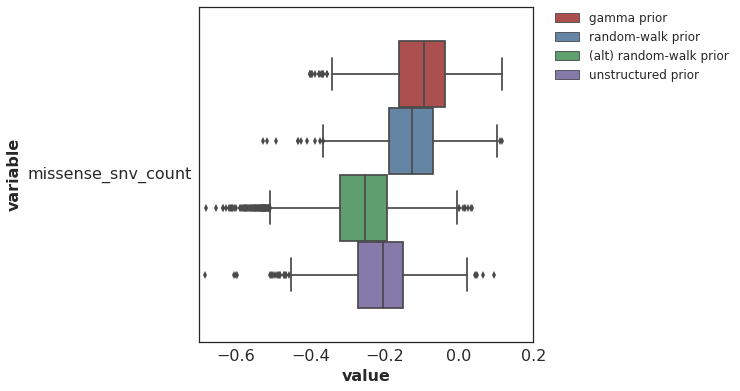

In [49]:
survivalstan.utils.plot_coefs([gamma_model, rw_model, rw2_model, uns_model])

### inspect baseline hazard functions

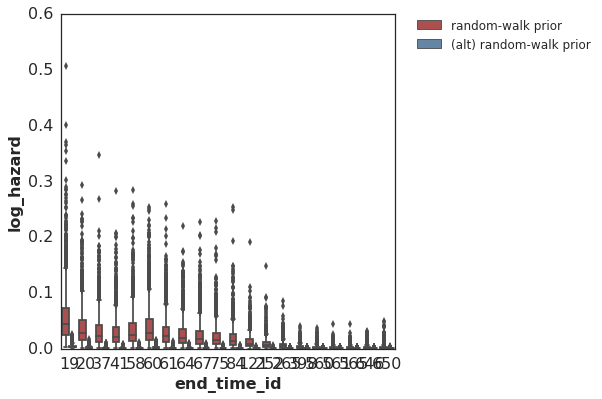

In [50]:
survivalstan.utils.plot_coefs([rw_model, rw2_model], element='baseline_raw')

### compare rw & gamma fit

In [51]:
stanity.loo_compare(gamma_model['loo'], rw_model['loo'])

{'diff': 21.861866886560342, 'se_diff': 5.8804260953187848}

In [52]:
stanity.loo_compare(rw_model['loo'], rw2_model['loo'])

{'diff': -8.5080703429676703, 'se_diff': 3.0586310236426866}

### bayesian p-value for p(mutation count >= 0)

In [53]:
coefdata = rw_model['coefs']
np.mean(coefdata.loc[coefdata['variable']=='missense_snv_count','value'] >= 0)

0.049000000000000002

## fit tvc-survival model in stan (naive)


First we will fit the "naive" time-varying covariate model in Stan, using the same method as above.

We will estimate a separate HR for `log_mut_centered` in (a) the first 90d, and (b) in the post-90d period.


In [54]:
dlong['lt_91_days'] = (dlong['end_time']<=91).astype(int)
dlong['gt_91_days'] = (dlong['end_time']>91).astype(int)

rw2_model_90d = survivalstan.fit_stan_survival_model(
    formula = '~ missense_snv_count:lt_91_days + missense_snv_count:gt_91_days',
    df = dlong,
    timepoint_end_col = 'end_time',
    sample_col = 'patient_id',
    event_col = 'end_failure',
    chains = 4,
    iter = 1000,
    model_code = survivalstan.models.pem_survival_model_randomwalk,
    model_cohort = 'random-walk baseline hazard, time-varying HR at 90d'
)

Reusing model.
Ran in 3.272 sec.


In [55]:
uns_model_90d = survivalstan.fit_stan_survival_model(
    formula = '~ missense_snv_count:lt_91_days + missense_snv_count:gt_91_days',
    df = dlong,
    timepoint_end_col = 'end_time',
    sample_col = 'patient_id',
    event_col = 'end_failure',
    chains = 4,
    iter = 1000,
    model_code = survivalstan.models.pem_survival_model_unstructured,
    model_cohort = 'uns baseline hazard, time-varying HR at 90d'
)

Reusing model.
Ran in 2.357 sec.


### compare coefficients for each model type

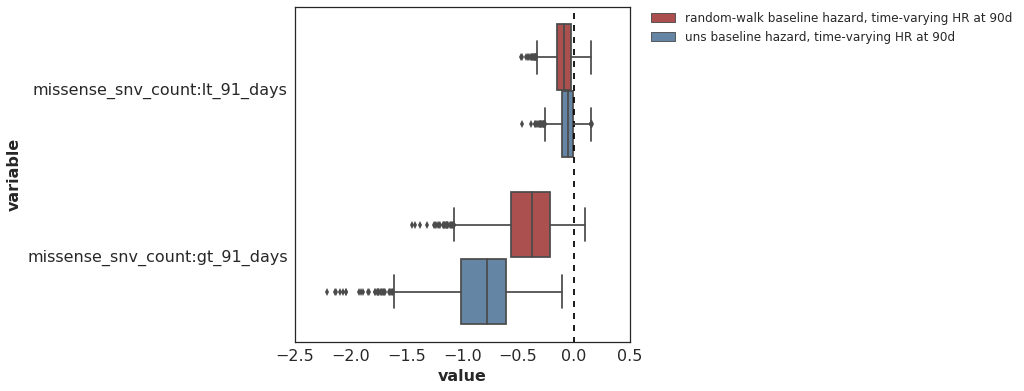

In [56]:
survivalstan.utils.plot_coefs([rw2_model_90d, uns_model_90d])
_ = plt.vlines(0, -10, 10, linestyles='--')

{{{hr-survival-by-90d}}}


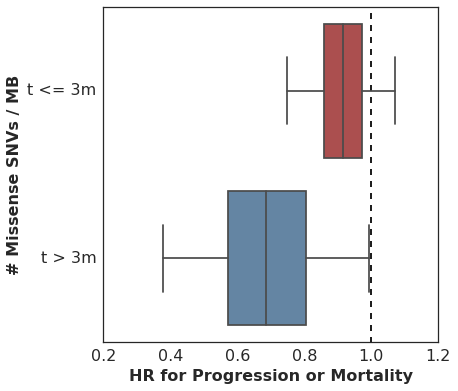

In [57]:
print('{{{hr-survival-by-90d}}}')
value, variable, coefdata = survivalstan.utils._prep_data_for_coefs([rw2_model_90d], 'coefs')
coefdata['exp(beta)'] = np.exp(coefdata[value])
coefdata['Missense SNV Count / MB'] = coefdata['variable']
sb.boxplot(data=coefdata, x='exp(beta)', y='Missense SNV Count / MB', fliersize=0, whis=[2.5, 97.5])
_ = plt.yticks([0, 1], ['t <= 3m', 't > 3m'])
_ = plt.vlines(1, -10, 10, linestyles='--')
_ = plt.ylabel('# Missense SNVs / MB')
_ = plt.xlabel('HR for {}'.format(cohort.hazard_plot_name))

In [58]:
## summarize coefficient estimates for caption
coefdata['group_label'] = coefdata.variable.apply(lambda x: 'hr_lt90d_rw2' if x=='missense_snv_count:lt_91_days' else 'hr_gt90d_rw2')
for name, group in coefdata.groupby('group_label'):
    paper.hyper_label_printer(formatter=paper.hr_posterior_formatter, label=name, series=group['exp(beta)'])


{{{hr_gt90d_rw2:HR=0.69, 95% CI (0.38, 0.99)}}}
{{{hr_lt90d_rw2:HR=0.91, 95% CI (0.75, 1.07)}}}


In [59]:
coefdata['group_label'] = coefdata.variable.apply(lambda x: 'hr_lt_90d_pfs' if x=='missense_snv_count:lt_91_days' else 'hr_gt_90d_pfs')
for name, group in coefdata.groupby('group_label'):
    if name=='hr_gt_90d_pfs':
        n=11
    else:
        n=25
    paper.hyper_label_printer(formatter=paper.hr_posterior_formatter, label=name, series=group['exp(beta)'], n=n)


{{{hr_gt_90d_pfs:n=11, HR=0.69, 95% CI (0.38, 0.99)}}}
{{{hr_lt_90d_pfs:n=25, HR=0.91, 95% CI (0.75, 1.07)}}}


### compare model fit using LOO-PSIS

In [60]:
stanity.loo_compare(rw2_model['loo'], rw2_model_90d['loo'])

{'diff': 8.2401167563348423, 'se_diff': 3.5026600683610822}

### Bayesian p-value for p(post-90d coefficient >= 0)

In [61]:
coefdata = rw2_model_90d['coefs']
np.mean(coefdata.loc[coefdata['variable']=='missense_snv_count:gt_91_days','value'] >= 0)

0.024

### Bayesian p-value for p(pre-90d coefficient > post-90d coefficient)

In [62]:
coefdata = rw2_model_90d['coefs']
1-(pd.pivot_table(coefdata,
                  index = ['iter', 'model_cohort'],
                  values = 'value', columns = 'variable').rename(
        columns = {'missense_snv_count:lt_91_days': 'lt_91_days',
                   'missense_snv_count:gt_91_days': 'gt_91_days'}).eval('lt_91_days > gt_91_days').mean())

0.097999999999999976

## bayesian tvc model for os endpoint

In [63]:
dlong_os['lt_91_days'] = (dlong_os['end_time']<=91).astype(int)
dlong_os['gt_91_days'] = (dlong_os['end_time']>91).astype(int)

rw2_model_90d_os = survivalstan.fit_stan_survival_model(
    formula = '~ missense_snv_count:lt_91_days + missense_snv_count:gt_91_days',
    df = dlong_os,
    timepoint_end_col = 'end_time',
    sample_col = 'patient_id',
    event_col = 'end_failure',
    chains = 4,
    iter = 1000,
    model_code = survivalstan.models.pem_survival_model_randomwalk,
    model_cohort = 'random-walk baseline hazard, time-varying HR at 90d'
)

Reusing model.
Ran in 4.042 sec.


{{{hr-survival-by-90d-os}}}


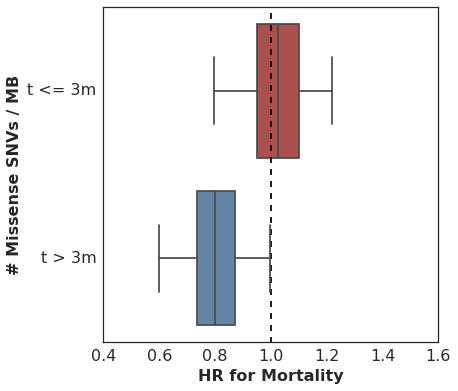

In [64]:
print('{{{hr-survival-by-90d-os}}}')
value, variable, coefdata = survivalstan.utils._prep_data_for_coefs([rw2_model_90d_os], 'coefs')
coefdata['exp(beta)'] = np.exp(coefdata[value])
coefdata['Missense SNV Count / MB'] = coefdata['variable']
sb.boxplot(data=coefdata, x='exp(beta)', y='Missense SNV Count / MB', fliersize=0, whis=[2.5, 97.5])
_ = plt.yticks([0, 1], ['t <= 3m', 't > 3m'])
_ = plt.vlines(1, -10, 10, linestyles='--')
_ = plt.ylabel('# Missense SNVs / MB')
_ = plt.xlabel('HR for {}'.format(cohort.hazard_os_plot_name))

In [65]:
coefdata['group_label'] = coefdata.variable.apply(lambda x: 'hr_lt90d_rw2_os' if x=='missense_snv_count:lt_91_days' else 'hr_gt90d_rw2_os')
for name, group in coefdata.groupby('group_label'):
    paper.hyper_label_printer(formatter=paper.hr_posterior_formatter, label=name, series=group['exp(beta)'])


{{{hr_gt90d_rw2_os:HR=0.80, 95% CI (0.60, 1.00)}}}
{{{hr_lt90d_rw2_os:HR=1.02, 95% CI (0.79, 1.22)}}}


In [66]:
coefdata['group_label'] = coefdata.variable.apply(lambda x: 'hr_lt_90d_os' if x=='missense_snv_count:lt_91_days' else 'hr_gt_90d_os')
for name, group in coefdata.groupby('group_label'):
    if name=='hr_gt_90d_os':
        n=11
    else:
        n=25
    paper.hyper_label_printer(formatter=paper.hr_posterior_formatter, label=name, series=group['exp(beta)'], n=n)


{{{hr_gt_90d_os:n=11, HR=0.80, 95% CI (0.60, 1.00)}}}
{{{hr_lt_90d_os:n=25, HR=1.02, 95% CI (0.79, 1.22)}}}


## fit tvc-survival model in stan (b-splines)

In [67]:
## load stan models again (for convenience)
models = survivalstan.utils.read_files('../utils/stan')

../utils/stan/logistic_model.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_expressed_missense_and_neoant_mutations.stan
../utils/stan/logistic_model_by_group.stan
../utils/stan/pem_survival_model_unstructured_varcoef.stan
../utils/stan/pem_survival_model_unstructured_varcoef_hsprior.stan
../utils/stan/pem_survival_model_randomwalk_tvc.stan
../utils/stan/pem_survival_model_randomwalk_alt.stan
../utils/stan/pem_survival_model_randomwalk_bspline_est_xi.stan
../utils/stan/pem_survival_model_varying_coefs3.stan
../utils/stan/pem_survival_model_randomwalk.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_rate_only.stan
../utils/stan/pem_survival_model_gamma.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_missense_and_neoant_rates.stan
../utils/stan/pem_survival_model_randomwalk_tvc2.stan
../utils/stan/pem_survival_model_varying_coefs2.stan
../utils/stan/pem_survival_model_varying_coefs4.stan
../utils/stan/pem_survival_model_randomwalk_bspline_est_xi2

### tvc with linear spline; fixed knot position

In [68]:
spline_model = survivalstan.fit_stan_survival_model(
    formula = '~ missense_snv_count',
    df = dlong,
    timepoint_end_col = 'end_time',
    sample_col = 'patient_id',
    event_col = 'end_failure',
    chains = 4,
    iter = 10000,
    model_code = models['pem_survival_model_randomwalk_bspline2.stan'],
    model_cohort = 'random-walk prior - linear spline',
    stan_data = {'H': 1, 'xi': [90], 'power': 1},
)

NOT reusing model.
Ran in 75.378 sec.


In [69]:
#print(spline_model['fit'])

In [70]:
stanity.loo_compare(rw_model['loo'],spline_model['loo'])

{'diff': -2.028895510333026, 'se_diff': 3.349026124632057}

In [71]:
stanity.loo_compare(rw2_model_90d['loo'], spline_model['loo'])

{'diff': -1.7609419237001978, 'se_diff': 2.4879856829408116}

In [72]:
def extract_time_betas(stanmodel, bins=20, element='beta_time', value_name='beta'):
    time_betas = stanmodel['fit'].extract()[element]
    time_betas = pd.DataFrame(time_betas[:,0,:])
    time_betas = pd.melt(time_betas, var_name = 'timepoint_id', value_name=value_name)
    timepoint_data = stanmodel['df'].loc[:,['timepoint_id','end_time']].drop_duplicates()
    time_betas = pd.merge(time_betas, timepoint_data, on = 'timepoint_id')
    time_betas['exp({})'.format(value_name)] = np.exp(time_betas[value_name])
    time_betas['model_cohort'] = stanmodel['model_cohort']
    time_betas['alt_timepoints'] = pd.cut(time_betas['end_time'],
                                          bins=bins,
                                          precision=0,
                                         )
    time_betas['alt_log_timepoints'] = pd.cut(np.log(time_betas['end_time']),
                                             bins=bins,
                                             precision=1,
                                             )
    rename_log_timepoints = np.exp(time_betas['alt_log_timepoints'].cat.categories.str.extract(', ([\d\.]+)\]', expand=False).astype(float)).astype(int)
    rename_timepoints = time_betas['alt_timepoints'].cat.categories.str.extract(', ([\d\.]+)\]', expand=False).astype(float).astype(int)
    time_betas['alt_timepoint_end'] = time_betas['alt_timepoints'].cat.rename_categories(rename_timepoints)
    time_betas['alt_log_timepoint_end'] = time_betas['alt_log_timepoints'].cat.rename_categories(rename_log_timepoints)
    time_betas['90d_post_therapy'] = time_betas.end_time.apply(lambda x: '>90d' if x > 90 else '<=90d')
    return(time_betas)

In [73]:
spline_model['time_betas'] = extract_time_betas(spline_model)

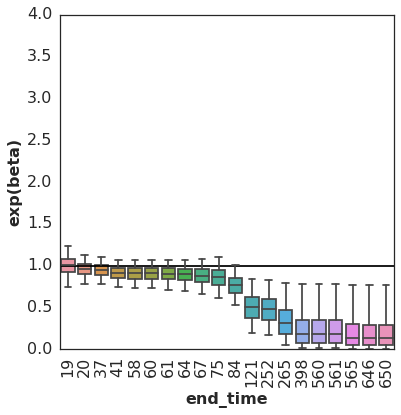

In [74]:
sb.boxplot(x = 'end_time', y = 'exp(beta)',
           data = spline_model['time_betas'],
           fliersize=0,
           whis=[2.5, 97.5],
          )
_ = plt.ylim([0, 4])
_ = plt.hlines(1, -1, 20)
_ = plt.xticks(rotation="vertical")

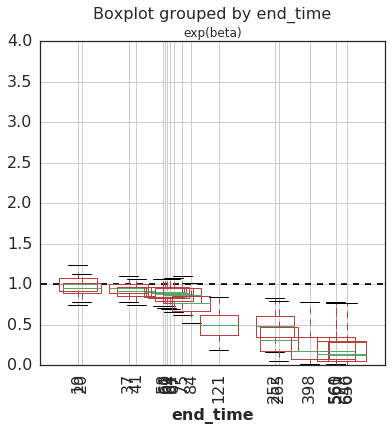

In [75]:
spline_model['time_betas'].boxplot(
    column='exp(beta)',
    by='end_time',
    whis=[2.5, 97.5],
    positions=np.log(spline_model['time_betas'].end_time.drop_duplicates())
)
_ = plt.ylim([0, 4])
_ = plt.hlines(1, -1, 20, linestyles='--')
_ = plt.xticks(rotation="vertical")


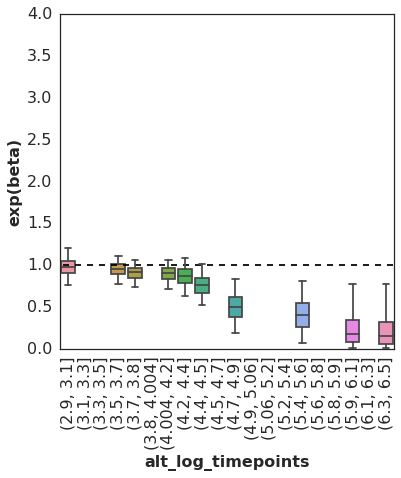

In [76]:
sb.boxplot(data = spline_model['time_betas'],
          x = 'alt_log_timepoints',
          y = 'exp(beta)',
           whis=[2.5, 97.5],
          fliersize=0,
          )
_ = plt.ylim([0, 4])
_ = plt.hlines(1, -1, 20, linestyles='--')
_ = plt.xticks(rotation="vertical")

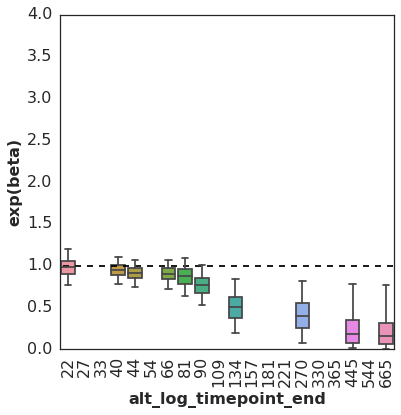

In [77]:
sb.boxplot(data = spline_model['time_betas'],
          x = 'alt_log_timepoint_end',
          y = 'exp(beta)',
           whis=[2.5, 97.5],
          fliersize=0,
          )
_ = plt.ylim([0, 4])
_ = plt.hlines(1, -1, 20, linestyles='--')
_ = plt.xticks(rotation="vertical")

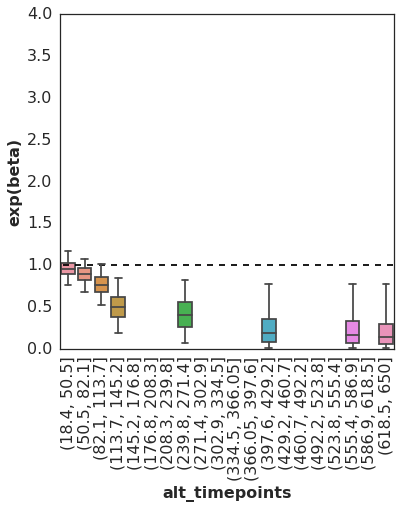

In [78]:
sb.boxplot(data = spline_model['time_betas'],
          x = 'alt_timepoints',
          y = 'exp(beta)',
           whis=[2.5, 97.5],
          fliersize=0,
          )
_ = plt.ylim([0, 4])
_ = plt.hlines(1, -1, 20, linestyles='--')
_ = plt.xticks(rotation="vertical")

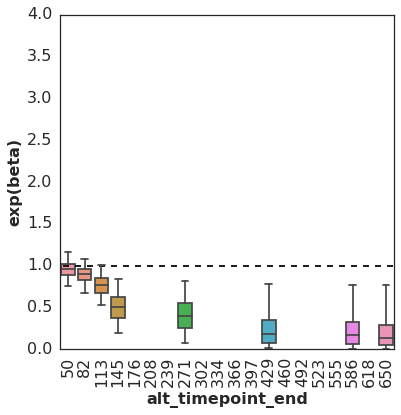

In [79]:
sb.boxplot(data = spline_model['time_betas'],
           x = 'alt_timepoint_end',
           y = 'exp(beta)',
           whis=[2.5, 97.5],
           fliersize=0,
           )
_ = plt.ylim([0, 4])
_ = plt.hlines(1, -1, 20, linestyles='--')
_ = plt.xticks(rotation="vertical")

### tvc with random-walk tvc

Goal of this model is to assess sensitivity to knot position & consequences of using a linear spline. 

Using a random-walk to model the nonlinear shape of the beta over the range of timepoints allows for more flexible modeling of the variance over time.

In [80]:
## load stan models again (for convenience)
models = survivalstan.utils.read_files('../utils/stan', pattern = "*.stan")

../utils/stan/logistic_model.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_expressed_missense_and_neoant_mutations.stan
../utils/stan/logistic_model_by_group.stan
../utils/stan/pem_survival_model_unstructured_varcoef.stan
../utils/stan/pem_survival_model_unstructured_varcoef_hsprior.stan
../utils/stan/pem_survival_model_randomwalk_tvc.stan
../utils/stan/pem_survival_model_randomwalk_alt.stan
../utils/stan/pem_survival_model_randomwalk_bspline_est_xi.stan
../utils/stan/pem_survival_model_varying_coefs3.stan
../utils/stan/pem_survival_model_randomwalk.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_rate_only.stan
../utils/stan/pem_survival_model_gamma.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_missense_and_neoant_rates.stan
../utils/stan/pem_survival_model_randomwalk_tvc2.stan
../utils/stan/pem_survival_model_varying_coefs2.stan
../utils/stan/pem_survival_model_varying_coefs4.stan
../utils/stan/pem_survival_model_randomwalk_bspline_est_xi2

In [81]:
tvc_model = survivalstan.fit_stan_survival_model(
    formula = '~ missense_snv_count',
    df = dlong,
    timepoint_end_col = 'end_time',
    sample_col = 'patient_id',
    event_col = 'end_failure',
    chains = 4,
    iter = 10000,
    model_code = models['pem_survival_model_randomwalk_tvc.stan'],
    model_cohort = 'random-walk prior - randomwalk tvc',
)

NOT reusing model.
Ran in 133.885 sec.


In [82]:
#print(tvc_model['fit'])

In [83]:
stanity.loo_compare(spline_model['loo'], tvc_model['loo'])

{'diff': 0.9011200537314632, 'se_diff': 1.895223005890716}

{{{time-varying-timepoint-id}}}


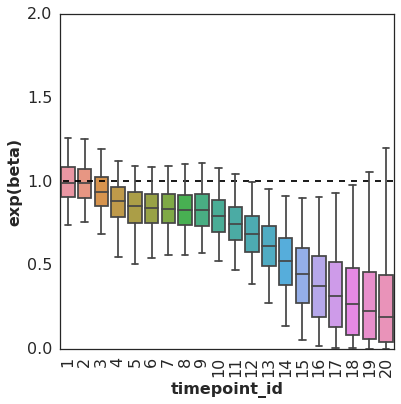

In [84]:
print('{{{time-varying-timepoint-id}}}')
tvc_model['time_betas'] = extract_time_betas(tvc_model)
sb.boxplot(x = 'timepoint_id',
           y = 'exp(beta)',
           data = tvc_model['time_betas'],
           whis=[2.5, 97.5],
           fliersize=0)
_ = plt.ylim([0, 2])
_ = plt.hlines(1, -1, 20, linestyles='--')
_ = plt.xticks(rotation='vertical')

{{{time-varying-timepoint-id-overlap}}}


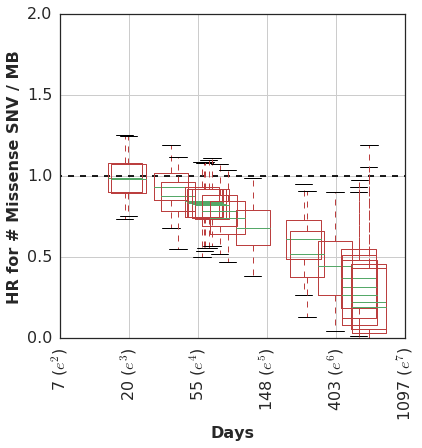

In [85]:
print('{{{time-varying-timepoint-id-overlap}}}')
f, ax = plt.subplots(1, 1)
x_min = min(np.log(tvc_model['time_betas'].end_time.drop_duplicates()))
x_max = max(np.log(tvc_model['time_betas'].end_time.drop_duplicates()))
time_varying_timepoint_id_overlap_plot = tvc_model['time_betas'].boxplot(
    column='exp(beta)',
    by='end_time',
    whis=[2.5, 97.5],
    positions=np.log(tvc_model['time_betas'].end_time.drop_duplicates()),
    ax=ax,
)
f.suptitle('')
_ = plt.ylim([0, 2])
_ = plt.hlines(1, -1, 20, linestyles='--')
_ = plt.xticks(rotation="vertical")
_ = plt.xlabel('Days')
_ = plt.ylabel('HR for # Missense SNV / MB')
_ = plt.title('')
_ = time_varying_timepoint_id_overlap_plot.xaxis.set_ticks([2, 3, 4, 5, 6, 7])
_ = time_varying_timepoint_id_overlap_plot.xaxis.set_ticklabels(
    [r"%d ($e^%d$) " % (int(round(np.exp(x))), x) for x in [2, 3, 4, 5, 6, 7]])

{{{time-varying-log-time}}}


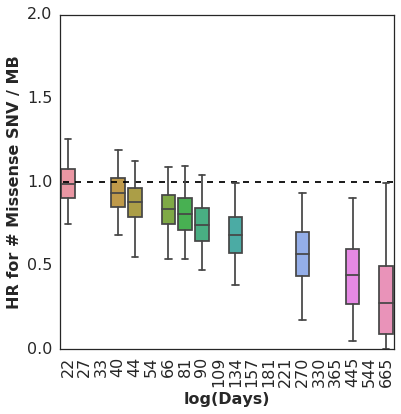

In [86]:
import matplotlib.axes as ax
print('{{{time-varying-log-time}}}')
sb.boxplot(x = 'alt_log_timepoint_end',
           y = 'exp(beta)',
           data = tvc_model['time_betas'],
           whis=[2.5, 97.5],
           fliersize=0)
_ = plt.ylim([0, 2])
_ = plt.hlines(1, -1, 20, linestyles='--')
_ = plt.xticks(rotation="vertical")
_ = plt.xlabel('log(Days)')
_ = plt.ylabel('HR for # Missense SNV / MB')


{{{time-varying-time}}}


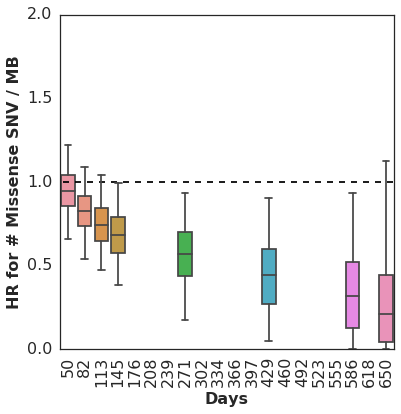

In [87]:
print('{{{time-varying-time}}}')
sb.boxplot(x = 'alt_timepoint_end',
           y = 'exp(beta)',
           data = tvc_model['time_betas'],
           whis=[2.5, 97.5],
           fliersize=0)
_ = plt.ylim([0, 2])
_ = plt.hlines(1, -1, 20, linestyles='--')
_ = plt.xticks(rotation="vertical")
_ = plt.xlabel('Days')
_ = plt.ylabel('HR for # Missense SNV / MB')


## plot estimated first-diff in beta for each timepoint 

In [88]:
# plot first-difference of timepoint-specific betas
tvc_model['time_beta_deltas'] = extract_time_betas(tvc_model, element='beta_time_deltas', value_name='beta_delta')

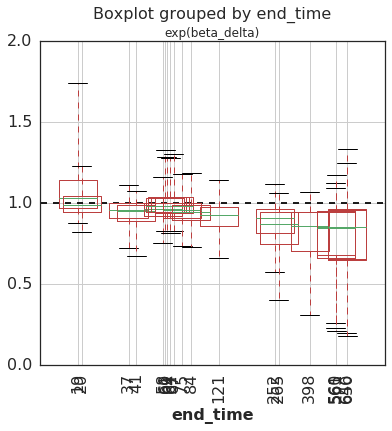

In [89]:
tvc_model['time_beta_deltas'].boxplot(
    column='exp(beta_delta)',
    by='end_time',
    whis=[2.5, 97.5],
    positions=np.log(tvc_model['time_beta_deltas'].end_time.drop_duplicates())
)
_ = plt.ylim([0, 2])
_ = plt.hlines(1, -1, 20, linestyles='--')
_ = plt.xticks(rotation="vertical")


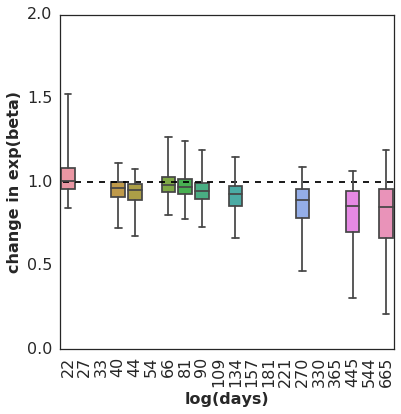

In [90]:
sb.boxplot(x = 'alt_log_timepoint_end',
           y = 'exp(beta_delta)',
           data = tvc_model['time_beta_deltas'],
           whis=[2.5, 97.5],
           fliersize=0)
_ = plt.ylim([0, 2])
_ = plt.hlines(1, -1, 20, linestyles='--')
_ = plt.xticks(rotation='vertical')
_ = plt.xlabel('log(days)')
_ = plt.ylabel('change in exp(beta)')

## compare estimated betas from each model

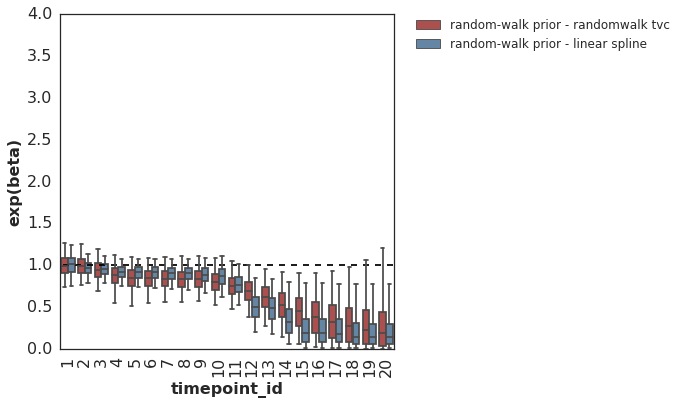

In [91]:
sb.boxplot(x = 'timepoint_id',
           y = 'exp(beta)',
           data = tvc_model['time_betas'].append(spline_model['time_betas']),
           hue = 'model_cohort',
           whis=[2.5, 97.5],
           fliersize=0)
_ = plt.ylim([0,4])
_ = plt.hlines(1, -1, 20, linestyles='--')
_ = plt.xticks(rotation='vertical')
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

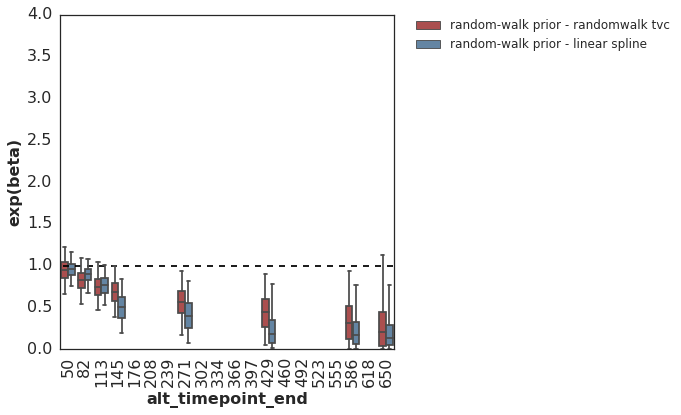

In [92]:
sb.boxplot(x = 'alt_timepoint_end',
           y = 'exp(beta)',
           data = tvc_model['time_betas'].append(spline_model['time_betas']),
           hue = 'model_cohort',
           whis=[2.5, 97.5],
           fliersize=0)
_ = plt.ylim([0,4])
_ = plt.hlines(1, -1, 20, linestyles='--')
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
_ = plt.xticks(rotation="vertical")

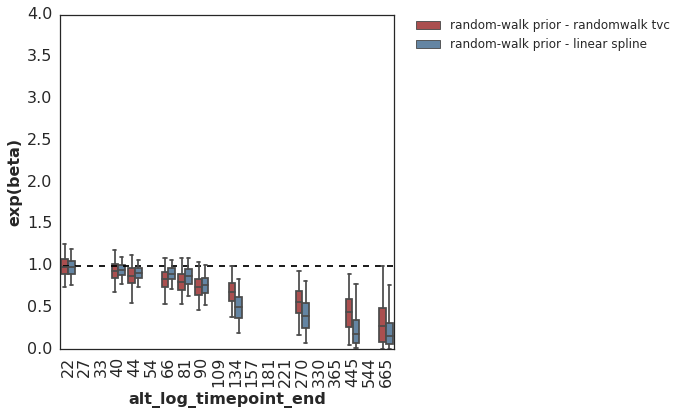

In [93]:
sb.boxplot(x = 'alt_log_timepoint_end',
           y = 'exp(beta)',
           data = tvc_model['time_betas'].append(spline_model['time_betas']),
           hue = 'model_cohort',
           whis=[2.5, 97.5],
           fliersize=0)
_ = plt.ylim([0,4])
_ = plt.hlines(1, -1, 20, linestyles='--')
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
_ = plt.xticks(rotation="vertical")

### tvc with linear spline; estimated knot position

In [94]:
## load stan models again (for convenience)
models = survivalstan.utils.read_files('../utils/stan', pattern = "*.stan")

../utils/stan/logistic_model.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_expressed_missense_and_neoant_mutations.stan
../utils/stan/logistic_model_by_group.stan
../utils/stan/pem_survival_model_unstructured_varcoef.stan
../utils/stan/pem_survival_model_unstructured_varcoef_hsprior.stan
../utils/stan/pem_survival_model_randomwalk_tvc.stan
../utils/stan/pem_survival_model_randomwalk_alt.stan
../utils/stan/pem_survival_model_randomwalk_bspline_est_xi.stan
../utils/stan/pem_survival_model_varying_coefs3.stan
../utils/stan/pem_survival_model_randomwalk.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_rate_only.stan
../utils/stan/pem_survival_model_gamma.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_missense_and_neoant_rates.stan
../utils/stan/pem_survival_model_randomwalk_tvc2.stan
../utils/stan/pem_survival_model_varying_coefs2.stan
../utils/stan/pem_survival_model_varying_coefs4.stan
../utils/stan/pem_survival_model_randomwalk_bspline_est_xi2

In [95]:
spline_model2 = survivalstan.fit_stan_survival_model(
    formula = '~ log_mut_centered',
    df = dlong,
    timepoint_end_col = 'end_time',
    sample_col = 'patient_id',
    event_col = 'end_failure',
    chains = 4,
    iter = 15000,
    model_code = models['pem_survival_model_randomwalk_bspline_est_xi2.stan'],
    model_cohort = 'random-walk prior - linear spline estimating knot',
    stan_data = {'H': 1, 'power': 1},
)

NOT reusing model.
Ran in 253.696 sec.


In [96]:
#print(spline_model2['fit'])

In [97]:
stanity.loo_compare(spline_model['loo'], spline_model2['loo'])

{'diff': 1.4327601373406302, 'se_diff': 2.513869849498461}

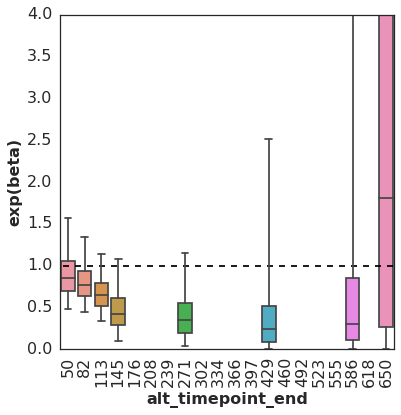

In [98]:
spline_model2['time_betas'] = extract_time_betas(spline_model2)
sb.boxplot(x = 'alt_timepoint_end',
           y = 'exp(beta)',
           data = spline_model2['time_betas'],
           whis=[2.5, 97.5],
           fliersize=0
          )
_ = plt.ylim([0,4])
_ = plt.xticks(rotation="vertical")
_ = plt.hlines(1, -1, 20, linestyles='--')

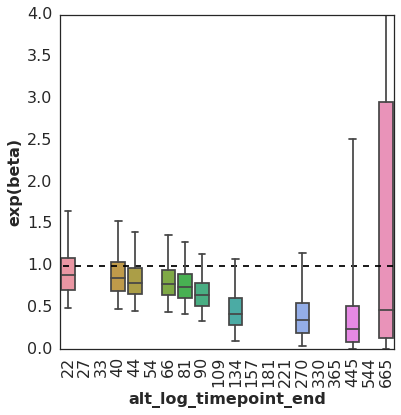

In [99]:
sb.boxplot(x = 'alt_log_timepoint_end',
           y = 'exp(beta)',
           data = spline_model2['time_betas'],
           whis=[2.5, 97.5],
           fliersize=0
          )
_ = plt.ylim([0,4])
_ = plt.xticks(rotation="vertical")
_ = plt.hlines(1, -1, 20, linestyles='--')

### tvc model with 2 breakpoints

In [100]:
spline_model_h2 = survivalstan.fit_stan_survival_model(
    formula = '~ log_mut_centered',
    df = dlong,
    timepoint_end_col = 'end_time',
    sample_col = 'patient_id',
    event_col = 'end_failure',
    chains = 4,
    iter = 15000,
    model_code = models['pem_survival_model_randomwalk_bspline_est_xi2.stan'],
    model_cohort = 'random-walk prior - linear spline estimating knot',
    stan_data = {'H': 2, 'power': 1},
)

Reusing model.
Ran in 312.013 sec.


In [101]:
# print(spline_model_h2['fit'])

In [102]:
stanity.loo_compare(spline_model['loo'], spline_model_h2['loo'])

{'diff': 1.4938997121271338, 'se_diff': 2.4096078316405589}

In [103]:
spline_model_h2['time_betas'] = extract_time_betas(spline_model_h2)

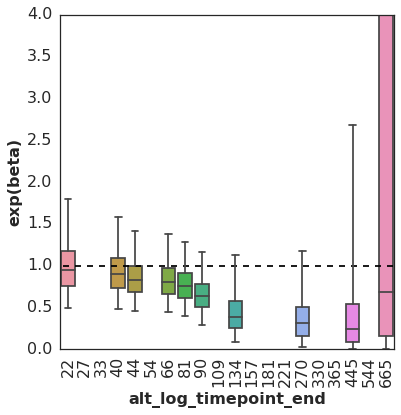

In [104]:
sb.boxplot(x = 'alt_log_timepoint_end',
           y = 'exp(beta)',
           data = spline_model_h2['time_betas'],
           whis=[2.5, 97.5],
           fliersize=0)
_ = plt.ylim([0,4])
_ = plt.hlines(1, -1, 400, linestyles='--')
_ = plt.xticks(rotation="vertical")

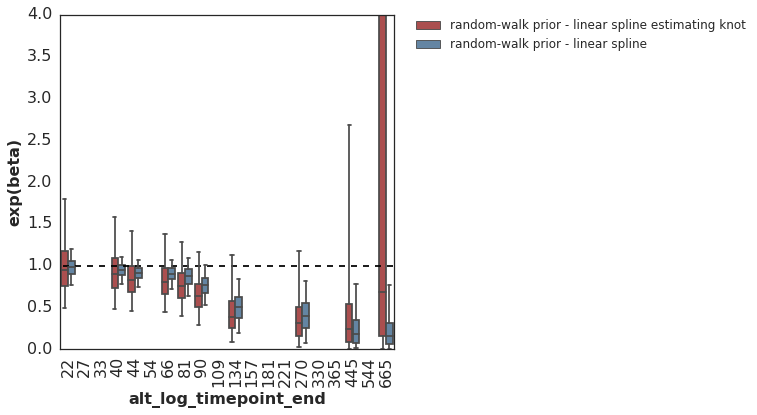

In [105]:
sb.boxplot(x = 'alt_log_timepoint_end',
           y = 'exp(beta)',
           data = spline_model_h2['time_betas'].append(spline_model['time_betas']),
           whis=[2.5, 97.5],
           hue = 'model_cohort',
           fliersize=0)
_ = plt.ylim([0,4])
_ = plt.hlines(1, -1, 200, linestyles='--')
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
_ = plt.xticks(rotation="vertical")